In [9]:
import os
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt

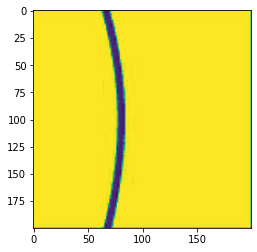

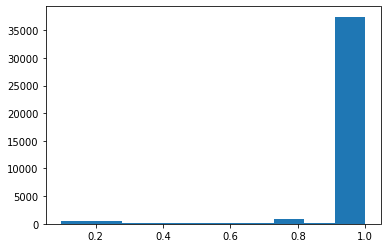

observations shape (1, 200, 200)


In [7]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'train.hdf5')
h5py_file = h5py.File(filename, 'r')
observations = h5py_file['dataset']['observations']
plt.imshow(observations[1000].swapaxes(0,1).swapaxes(1,2)[:,:,0])
plt.show()
plt.hist(observations[1000].flatten())
plt.show()
print(f'observations shape {observations[0].shape}')

In [8]:
len(observations)

3025

(1, 200, 200)


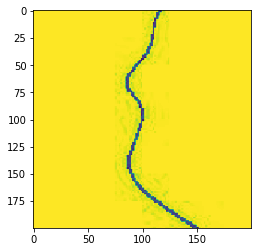

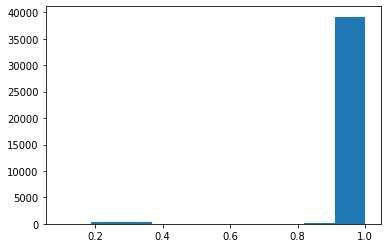

In [3]:
# change shape
size = [1, 200, 200]
preprocessed_observations = [
    cv2.resize(o.swapaxes(0,1).swapaxes(1,2), dsize=(size[1], size[2]), 
               interpolation=cv2.INTER_NEAREST).mean(axis=-1, keepdims=True).swapaxes(1, 2).swapaxes(0, 1) 
    for o in observations
]
print(preprocessed_observations[0].shape)
plt.imshow(preprocessed_observations[1000][0])
plt.show()
plt.hist(preprocessed_observations[1000].flatten())
plt.show()

In [4]:
# write preprocessed images to new h5py file:
filename = '/home/klaas/line_world_sim_dronet.hdf5'
new_h5py_file = h5py.File(filename, 'w')
h5py_dataset = new_h5py_file.create_group('dataset')
for tag, data in zip(['observations', 'actions', 'done'],
        [preprocessed_observations, h5py_file['dataset']['actions'], h5py_file['dataset']['done']]):
    h5py_dataset[tag] = np.asarray(data)
new_h5py_file.close()

In [5]:
# threshold regions in image
threshold = 0.5
binary_images = [
    cv2.threshold(o[0],0.5,1,cv2.THRESH_BINARY)[1] for o in observations
]
print(binary_images[0])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [6]:
# fill in zero (fg) and one (bg) regions
final_images = []
for img in binary_images:
    # pick bg and fg color
    minimal_contrast = 0.1
    bg = np.random.uniform(0, 1)
    fg = np.random.uniform(0, 1)
    while bg-fg > minimal_contrast:
        fg = np.random.uniform(0, 1)
    img[img==0] = fg
    img[img==1] = bg
    final_images.append(np.expand_dims(img, axis=0))
    
assert final_images[0].shape == (1, 200, 200)

In [7]:
# write augmented dataset
filename = '/home/klaas/line_world_sim_dronet_augmented.hdf5'
new_h5py_file = h5py.File(filename, 'w')
h5py_dataset = new_h5py_file.create_group('dataset')
for tag, data in zip(['observations', 'actions', 'done'],
        [final_images, h5py_file['dataset']['actions'], h5py_file['dataset']['done']]):
    h5py_dataset[tag] = np.asarray(data)
new_h5py_file.close()

In [6]:
# create noise augmented dataset
final_images = []
for img in binary_images:
    bg = np.random.uniform(0, 1, size=img.shape)
    fg = np.zeros(img.shape) + np.random.uniform(0, 1)
    new_img = (-(img - 1) * fg + img * bg)/2.
    final_images.append(np.expand_dims(new_img, axis=0))

In [8]:
# write noise augmented dataset
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'line_world_sim_dronet_noise_augmented.hdf5')
new_h5py_file = h5py.File(filename, 'w')
h5py_dataset = new_h5py_file.create_group('dataset')
for tag, data in zip(['observations', 'actions', 'done'],
        [final_images, h5py_file['dataset']['actions'], h5py_file['dataset']['done']]):
    h5py_dataset[tag] = np.asarray(data)
new_h5py_file.close()

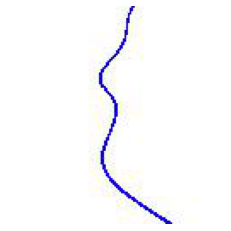

observations shape (3, 128, 128)


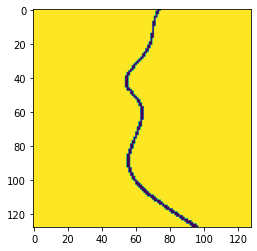

In [19]:
################################################################################
# Create binary dataset with 3x256x256 input and 1x128x128 binary output       #
# input should be in range of -1:1
################################################################################

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'line_world_sim_128x128x3_wp.hdf5')
h5py_file = h5py.File(filename, 'r')
observations = h5py_file['dataset']['observations']
index = 1000
plt.imshow(observations[index].swapaxes(0,1).swapaxes(1,2)[:,:,:])
plt.axis('off')
plt.show()
print(f'observations shape {observations[0].shape}')
# extract binary target images
threshold = 0.5
binary_images = [
    cv2.threshold(o.mean(axis=0, keepdims=True), 0.5, 1, cv2.THRESH_BINARY)[1] for o in observations
]
# ensure not everything is white
assert binary_images[0].sum() != binary_images[0].shape[1] * binary_images[0].shape[2]
plt.imshow(binary_images[index][0])
plt.show()
# augment input image with three color noise

